#### **Note: This notebook will adjust pre-processing steps to remove additional noise in hopes of improving the models**

In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Tensorflow
import tensorflow as tf

# Pickle
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Import data
df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [4]:
# Drop the EIN and Name columns
cols = ["EIN", "NAME"]
df.drop(columns=cols, inplace=True)
df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


Given the value counts, Application Type and Classification look like they'll need to be binned.

In [5]:
# Value counts for Application Type
df.APPLICATION_TYPE.value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
T9,156


In [6]:
# Set limit for "Other" bin
limit = 250
atc = df.APPLICATION_TYPE.value_counts()
app_to_replace = atc.loc[atc < limit].index.tolist()

# Replace values in DataFrame
for app in app_to_replace:
  df["APPLICATION_TYPE"] = df.APPLICATION_TYPE.replace(app, "Other")

# Verify "Other" bin
df.APPLICATION_TYPE.value_counts()

,count
APPLICATION_TYPE,
T3,27037
T4,1542
T6,1216
T5,1173
T19,1065
T8,737
T7,725
T10,528
Other,276


In [7]:
# Value counts for Classification
df.CLASSIFICATION.value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
...,...
C4120,1
C8210,1
C2561,1


In [8]:
# Set limit for "Other" bin
limit = 300
cvc = df.CLASSIFICATION.value_counts()
cat_to_replace = cvc.loc[cvc < limit].index.tolist()

# Replace values in DataFrame
for cat in cat_to_replace:
  df["CLASSIFICATION"] = df.CLASSIFICATION.replace(cat, "Other")

# Verify "Other" bin
df.CLASSIFICATION.value_counts()

,count
CLASSIFICATION,
C1000,17326
C2000,6074
C1200,4837
C3000,1918
C2100,1883
Other,1484
C7000,777


In [9]:
df.columns

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

In [10]:
cols = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL']

for col in cols:
 print(df[col].value_counts())

APPLICATION_TYPE
T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: count, dtype: int64
AFFILIATION
Independent         18480
CompanySponsored    15705
Family/Parent          64
National               33
Regional               13
Other                   4
Name: count, dtype: int64
CLASSIFICATION
C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: count, dtype: int64
USE_CASE
Preservation     28095
ProductDev        5671
CommunityServ      384
Heathcare          146
Other                3
Name: count, dtype: int64
ORGANIZATION
Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: count, dtype: int64
STATUS
1    34294
0        5
Name: count, dtype: int64
INCOME_AMT
0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
1

Looking at the value counts of each column, the following is going to be done in addition to the binning for Classification and Application Type:
1. Drop: Status, Special Considerations
2. Bin: Affiliation, Organization, Use Case

In [11]:
# Drop the Status, Special Considerations, and Use Case columns
cols = ["STATUS", "SPECIAL_CONSIDERATIONS"]
df.drop(columns=cols, inplace=True)
df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1


In [12]:
# Value counts for Use Case
df.USE_CASE.value_counts()

,count
USE_CASE,
Preservation,28095
ProductDev,5671
CommunityServ,384
Heathcare,146
Other,3


In [13]:
# Set limit for "Other" bin
limit = 10000
usvc = df.USE_CASE.value_counts()
us_to_replace = usvc.loc[usvc < limit].index.tolist()

# Replace values in DataFrame
for us in us_to_replace:
  df["USE_CASE"] = df.USE_CASE.replace(us, "Other")

# Verify "Other" bin
df.USE_CASE.value_counts()

,count
USE_CASE,
Preservation,28095
Other,6204


In [14]:
# Value counts for Affiliation
df.AFFILIATION.value_counts()

,count
AFFILIATION,
Independent,18480
CompanySponsored,15705
Family/Parent,64
National,33
Regional,13
Other,4


In [15]:
# Set limit for "Other" bin
limit = 1000
afvc = df.AFFILIATION.value_counts()
aff_to_replace = afvc.loc[afvc < limit].index.tolist()

# Replace values in DataFrame
for aff in aff_to_replace:
  df["AFFILIATION"] = df.AFFILIATION.replace(aff, "Other")

# Verify "Other" bin
df.AFFILIATION.value_counts()

,count
AFFILIATION,
Independent,18480
CompanySponsored,15705
Other,114


In [16]:
# Value counts for Organization
df.ORGANIZATION.value_counts()

,count
ORGANIZATION,
Trust,23515
Association,10255
Co-operative,486
Corporation,43


In [17]:
# Set limit for "Other" bin
limit = 1000
orgvc = df.ORGANIZATION.value_counts()
org_to_replace = orgvc.loc[orgvc < limit].index.tolist()

# Replace values in DataFrame
for org in org_to_replace:
  df["ORGANIZATION"] = df.ORGANIZATION.replace(org, "Other")

# Verify "Other" bin
df.ORGANIZATION.value_counts()

,count
ORGANIZATION,
Trust,23515
Association,10255
Other,529


In [18]:
display(df.columns)
df.info()

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'INCOME_AMT', 'ASK_AMT', 'IS_SUCCESSFUL'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   APPLICATION_TYPE  34299 non-null  object
 1   AFFILIATION       34299 non-null  object
 2   CLASSIFICATION    34299 non-null  object
 3   USE_CASE          34299 non-null  object
 4   ORGANIZATION      34299 non-null  object
 5   INCOME_AMT        34299 non-null  object
 6   ASK_AMT           34299 non-null  int64 
 7   IS_SUCCESSFUL     34299 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.1+ MB


In [19]:
# One-hot encode categorical columns
cat_cols = ['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION',
       'ORGANIZATION', 'INCOME_AMT', "USE_CASE"]

# copy the original dataframe to preserve pre-processing done to this point
df1 = df.copy()

# Use pd.get_dummies
df1 = pd.get_dummies(df1, columns=cat_cols, dtype=int)
df1.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,USE_CASE_Other,USE_CASE_Preservation
0,5000,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,108590,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,5000,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,6692,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,142590,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [20]:
# Scale the Ask Amount Column with MinMaxScaler
# apply normalization techniques on Column 1
column = 'ASK_AMT'
df1[column] = MinMaxScaler().fit_transform(np.array(df1[column]).reshape(-1,1))

# view normalized data
df1.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,USE_CASE_Other,USE_CASE_Preservation
0,0.000000e+00,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1.204843e-05,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2,0.000000e+00,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1.967945e-07,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,1.600293e-05,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [21]:
# Train-Test-Split
# Get the Data
X = df1.drop(columns=["IS_SUCCESSFUL"])
y = df1.IS_SUCCESSFUL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

print(X_train.shape, X_test.shape)

(25724, 34) (8575, 34)


#### Network 7:
---
Same settings as Network 5, but with data processed differently

In [22]:
# Create the Keras Sequential model
nn_model7 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model7.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model7.add(tf.keras.layers.Dense(units=13, activation="relu"))

# Add in a third layer
nn_model7.add(tf.keras.layers.Dense(units=11, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model7.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │             525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 11)                  │             154 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 899 (3.51 KB)

 Trainable params: 899 (3.51 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Early Stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model7 = nn_model7.fit(X_train, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6637 - loss: 0.6247
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7271 - loss: 0.5598
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7265 - loss: 0.5573
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7291 - loss: 0.5540
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7298 - loss: 0.5481
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7252 - loss: 0.5547
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7337 - loss: 0.5440
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7274 - loss: 0.5546
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7312 - loss: 0.5484
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7323 - loss: 0.5449
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7302 - loss: 0.5514
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

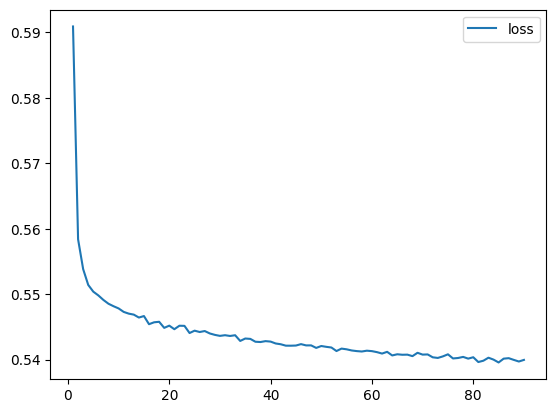

In [24]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model7.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

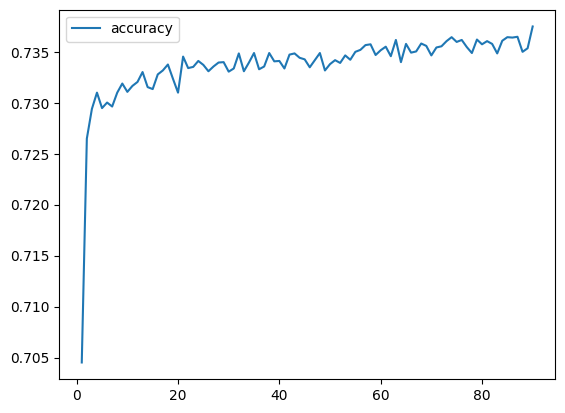

In [25]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model7.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 2ms/step - accuracy: 0.7305 - loss: 0.5543
Loss: 0.554299533367157, Accuracy: 0.7304956316947937


Summary: Performs the best of all of the models.

Per this, the primary issue was likely the scaling.

### Additional Pre-processing
---
Dropping: Affiliation, Organization, and Use Case\
Reason: Tail values are so under represented that these features are unlikely to have much predictive power.

If this doesn't improve performance, then these features are likely important

In [27]:
# Copy the original dataframe for additional pre-processing steps
df2 = df.copy()
df2.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,Other,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Other,1-9999,108590,1
2,T5,CompanySponsored,C3000,Other,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Other,Trust,100000-499999,142590,1


In [28]:
# Drop the Affiliation, Organization, and Use Case columns
cols = ["AFFILIATION", "ORGANIZATION", "USE_CASE"]
df2.drop(columns=cols, inplace=True)
df2.head()

,APPLICATION_TYPE,CLASSIFICATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,C1000,0,5000,1
1,T3,C2000,1-9999,108590,1
2,T5,C3000,0,5000,0
3,T3,C2000,10000-24999,6692,1
4,T3,C1000,100000-499999,142590,1


In [29]:
# Scale the Ask Amount Column with MinMaxScaler
# apply normalization techniques on Column 1
column = 'ASK_AMT'
df2[column] = MinMaxScaler().fit_transform(np.array(df2[column]).reshape(-1,1))

# view normalized data
df2.head()

,APPLICATION_TYPE,CLASSIFICATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,C1000,0,0.000000e+00,1
1,T3,C2000,1-9999,1.204843e-05,1
2,T5,C3000,0,0.000000e+00,0
3,T3,C2000,10000-24999,1.967945e-07,1
4,T3,C1000,100000-499999,1.600293e-05,1


In [30]:
# One-hot encode categorical columns
cat_cols = ['APPLICATION_TYPE', 'CLASSIFICATION', 'INCOME_AMT']

# Use pd.get_dummies
df2 = pd.get_dummies(df2, columns=cat_cols, dtype=int)
df2.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.000000e+00,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1.204843e-05,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.000000e+00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,1.967945e-07,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.600293e-05,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [31]:
# Train-Test-Split
# Get the Data
X = df2.drop(columns=["IS_SUCCESSFUL"])
y = df2.IS_SUCCESSFUL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

print(X_train.shape, X_test.shape)

(25724, 26) (8575, 26)


### Network 8:
---

In [32]:
# Create the Keras Sequential model
nn_model8 = tf.keras.models.Sequential()

# Add our first Dense layer (hidden layer), including the input layer
# input_dim only in 1st layer
nn_model8.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=len(X.columns)))

# Add in a second layer
# Use fewer layers than the 1st one
nn_model8.add(tf.keras.layers.Dense(units=13, activation="relu"))

# Add in a third layer
nn_model8.add(tf.keras.layers.Dense(units=11, activation="relu"))

# Add the output layer that uses a probability activation function
nn_model8.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the Sequential model
nn_model8.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 15)                  │             405 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 13)                  │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 11)                  │             154 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 779 (3.04 KB)

 Trainable params: 779 (3.04 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Early Stop
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Compile the Sequential model together and customize metrics
nn_model8.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model8 = nn_model8.fit(X_train, y_train, epochs=500, callbacks=[stop_early])

Epoch 1/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5771 - loss: 0.6735
Epoch 2/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6209 - loss: 0.6383
Epoch 3/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6284 - loss: 0.6363
Epoch 4/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6255 - loss: 0.6342
Epoch 5/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6289 - loss: 0.6297
Epoch 6/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6266 - loss: 0.6314
Epoch 7/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6214 - loss: 0.6349
Epoch 8/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6297 - loss: 0.6307
Epoch 9/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6207 - loss: 0.6342
Epoch 10/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6259 - loss: 0.6338
Epoch 11/500
804/804 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6243 - loss: 0.6319
Epoch 12/500
804/804 ━━━━━━━━━━━━━━━━━━━━

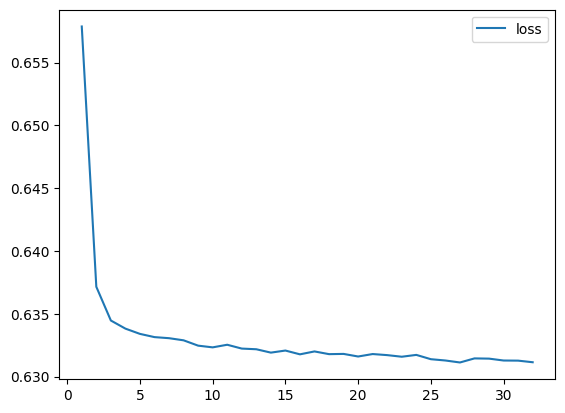

In [34]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model8.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")
plt.show()

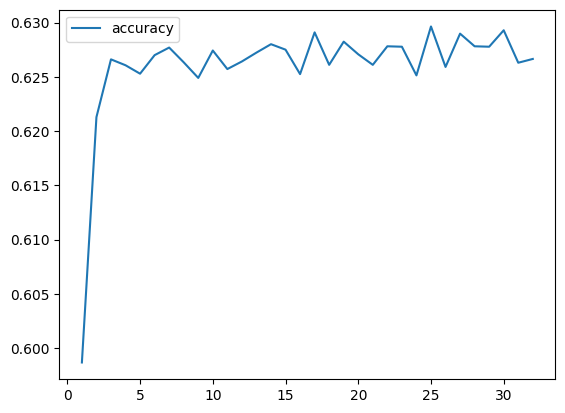

In [35]:
# Plot the accuracy
history_df.plot(y="accuracy")
plt.show()

In [36]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model8.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - 2ms/step - accuracy: 0.6227 - loss: 0.6382
Loss: 0.6382167339324951, Accuracy: 0.6227405071258545


Summary: This model performs better than all models in the inital notebook (except for the Keras-Tuner model), but worse than Network 7. As a result, it is likely that the 3 dropped columns did in fact provide predictive value.

### Export the model

In [37]:
# Save the best model created without the keras-tuner (Network 2)
nn_model7.save("best_nn_model.h5")